# Navier-Stokes 2D en Base de Bernstein

**Solver RK4 para NS 2D incompresible usando discretización Galerkin en base de Bernstein**

Referencia: Sánchez & Ainsworth (2020), Temam (2001)

## Ecuaciones

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u}$$

$$\nabla \cdot \mathbf{u} = 0$$

donde $\mathbf{u} = (u,v)$ es velocidad, $p$ es presión, $\nu$ es viscosidad.

## Sección 1: Importar Librerías

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import sys
import os

# Setup path
sys.path.insert(0, '/Users/estebanroman/Documents/GitHub/NewtonBernstein/python')

# Estilos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas")

✓ Librerías importadas


## Sección 2: Importar Solver NS 2D

In [12]:
from navier_stokes_2d import NavierStokes2D

print("✓ Solver Navier-Stokes 2D importado")

✓ Solver Navier-Stokes 2D importado


## Sección 3: Caso 1 - Flujo de Poiseuille 2D

**Problema**: Flujo de Poiseuille completamente desarrollado
- Solución analítica conocida
- Flujo laminar entre dos paredes
- Velocidad parabólica: $u(y) = 4y(1-y)$, $v = 0$

In [13]:
# Parámetros más conservadores
degree_ns = 12  # Reducir grado
viscosity_ns = 0.1  # Aumentar viscosidad para estabilidad
t_final_ns = 0.5   # Reducir tiempo final
dt_ns = 0.001      # Reducir paso de tiempo
domain_ns = (0, 1)

# Crear solver
print("Creando solver Navier-Stokes 2D...")
ns_solver = NavierStokes2D(
    degree=degree_ns,
    viscosity=viscosity_ns,
    domain=domain_ns,
    verbose=True
)

# Condición inicial: Poiseuille
# Flujo entre dos placas paralelas
u_init_poiseuille = lambda x, y: 0.1 * 4.0 * y * (1.0 - y)  # Escalar para estabilidad
v_init_poiseuille = lambda x, y: 0.0 * x  # v = 0

print("\nResolviendo Poiseuille 2D...")
times_ps, sols_u_ps, sols_v_ps = ns_solver.solve(
    u_init=u_init_poiseuille,
    v_init=v_init_poiseuille,
    t_final=t_final_ns,
    dt=dt_ns,
    save_freq=1
)

print(f"\n✓ Resolución completada")
print(f"  Snapshots guardados: {len(times_ps)}")
print(f"  Tiempo final: {times_ps[-1]:.4f}")

Creando solver Navier-Stokes 2D...
✓ NavierStokes2D inicializado
  Grado: 12, Modos: 13² = 169
  Viscosidad: 0.1
  Dominio: [0.00, 1.00]²
  Cuadratura: 30² = 900 puntos

Resolviendo Poiseuille 2D...

✓ Iniciando integración NS 2D RK4
  Pasos totales: 500
  Guardando cada 1 pasos
  Paso 50/500, t=0.050
  Paso 100/500, t=0.100
  Paso 150/500, t=0.150
  Paso 200/500, t=0.200
  Paso 250/500, t=0.250
  Paso 300/500, t=0.300
  Paso 350/500, t=0.350
  Paso 400/500, t=0.400
  Paso 450/500, t=0.450
  Paso 500/500, t=0.500
✓ Integración completada en t=0.500


✓ Resolución completada
  Snapshots guardados: 501
  Tiempo final: 0.5000


## Sección 4: Visualizar Poiseuille - Campos de Velocidad

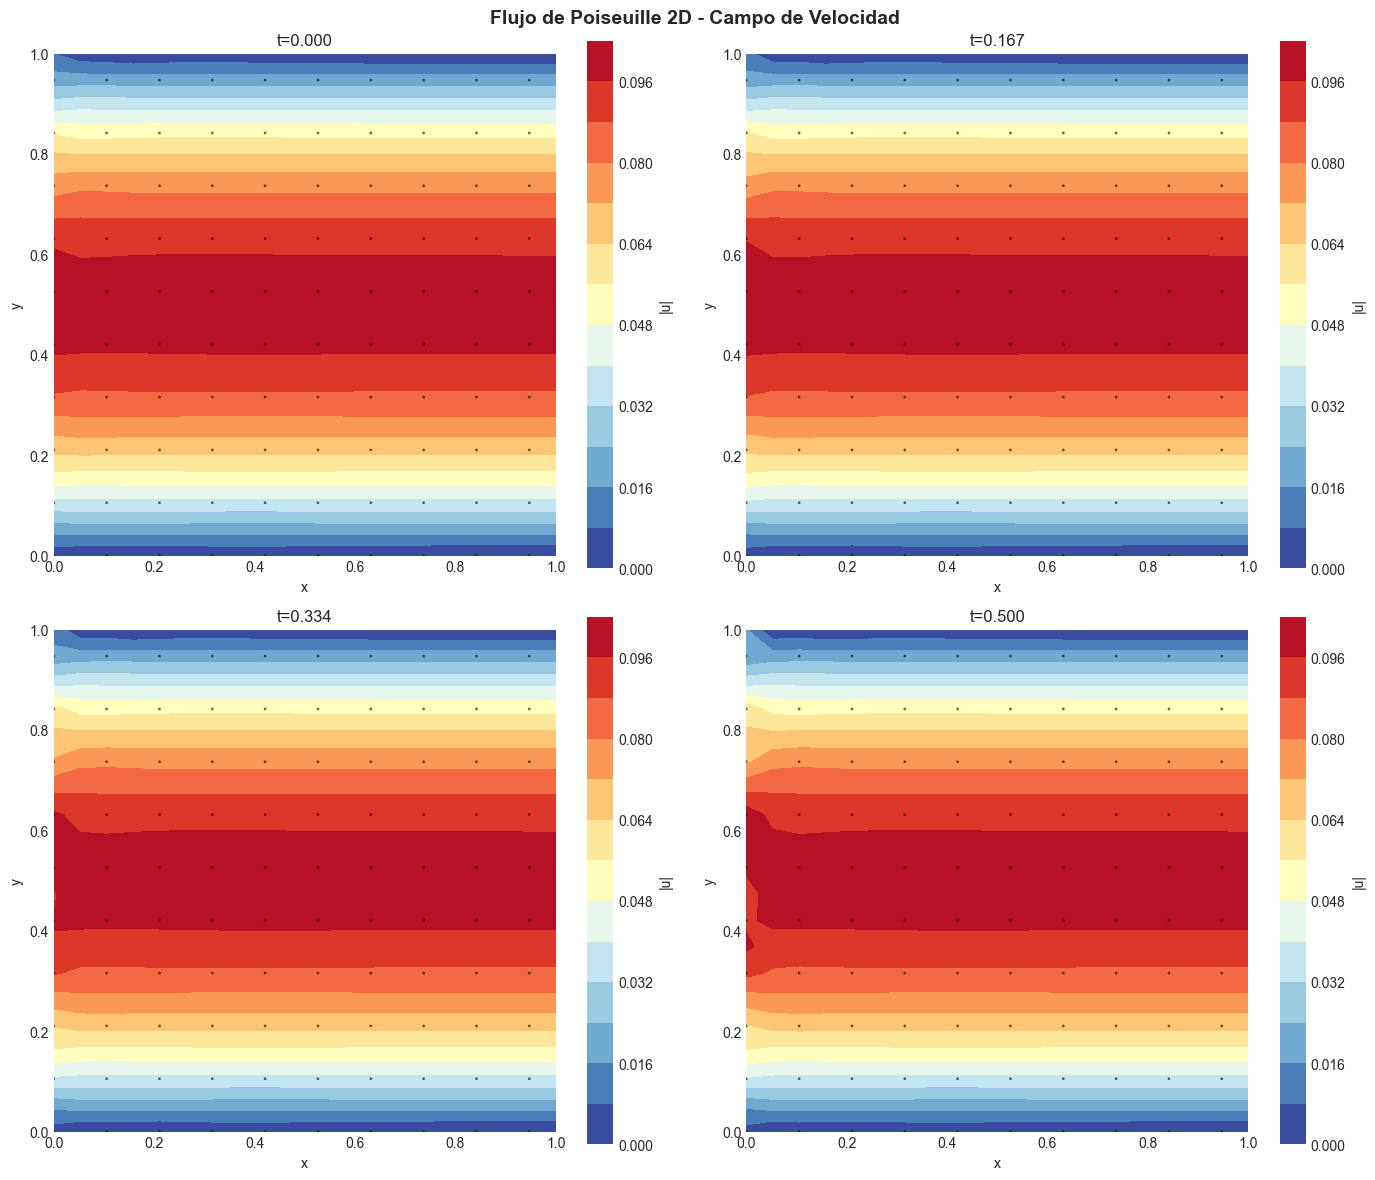

✓ Visualización Poiseuille completada


In [14]:
# Crear grid de visualización
n_vis = 20
x_vis = np.linspace(0, 1, n_vis)
y_vis = np.linspace(0, 1, n_vis)
X_vis, Y_vis = np.meshgrid(x_vis, y_vis, indexing='ij')

# Evaluar solución en tiempos seleccionados
times_select = [0, len(times_ps)//3, 2*len(times_ps)//3, len(times_ps)-1]
labels_select = [f"t={times_ps[t]:.3f}" for t in times_select]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Flujo de Poiseuille 2D - Campo de Velocidad', fontsize=14, fontweight='bold')

for idx, (t_idx, label) in enumerate(zip(times_select, labels_select)):
    ax = axes.flat[idx]
    
    # Evaluar velocidades
    u_vis, v_vis = ns_solver.evaluate(X_vis.flatten(), Y_vis.flatten(), 
                                       sols_u_ps[t_idx], sols_v_ps[t_idx])
    u_vis = u_vis.reshape(X_vis.shape)
    v_vis = v_vis.reshape(Y_vis.shape)
    
    # Magnitud de velocidad
    vel_mag = np.sqrt(u_vis**2 + v_vis**2)
    
    # Contorno
    contour = ax.contourf(X_vis, Y_vis, vel_mag, levels=15, cmap='RdYlBu_r')
    plt.colorbar(contour, ax=ax, label='|u|')
    
    # Quiver (flechas)
    skip = 2
    ax.quiver(X_vis[::skip, ::skip], Y_vis[::skip, ::skip], 
              u_vis[::skip, ::skip], v_vis[::skip, ::skip],
              scale=30, alpha=0.6)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(label)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("✓ Visualización Poiseuille completada")

## Sección 5: Caso 2 - Vórtice Rotante (Rotating Vortex)

In [15]:
# Crear nuevo solver para vórtice con parámetros estables
ns_solver_vortex = NavierStokes2D(
    degree=degree_ns,
    viscosity=0.05,  # Viscosidad moderada
    domain=domain_ns,
    verbose=False
)

# Vórtice rotante: u = -sin(πy)cos(πx), v = sin(πx)cos(πy)
# Campo de velocidad rotacional puro
u_init_vortex = lambda x, y: -0.05 * np.sin(np.pi*y) * np.cos(np.pi*x)
v_init_vortex = lambda x, y: 0.05 * np.sin(np.pi*x) * np.cos(np.pi*y)

print("Resolviendo Vórtice Rotante 2D...")
times_vx, sols_u_vx, sols_v_vx = ns_solver_vortex.solve(
    u_init=u_init_vortex,
    v_init=v_init_vortex,
    t_final=t_final_ns,
    dt=dt_ns,
    save_freq=1
)

print(f"✓ Resolución completada - {len(times_vx)} snapshots")

Resolviendo Vórtice Rotante 2D...
✓ Resolución completada - 501 snapshots


## Sección 6: Visualizar Vórtice - Vorticidad y Streamlines

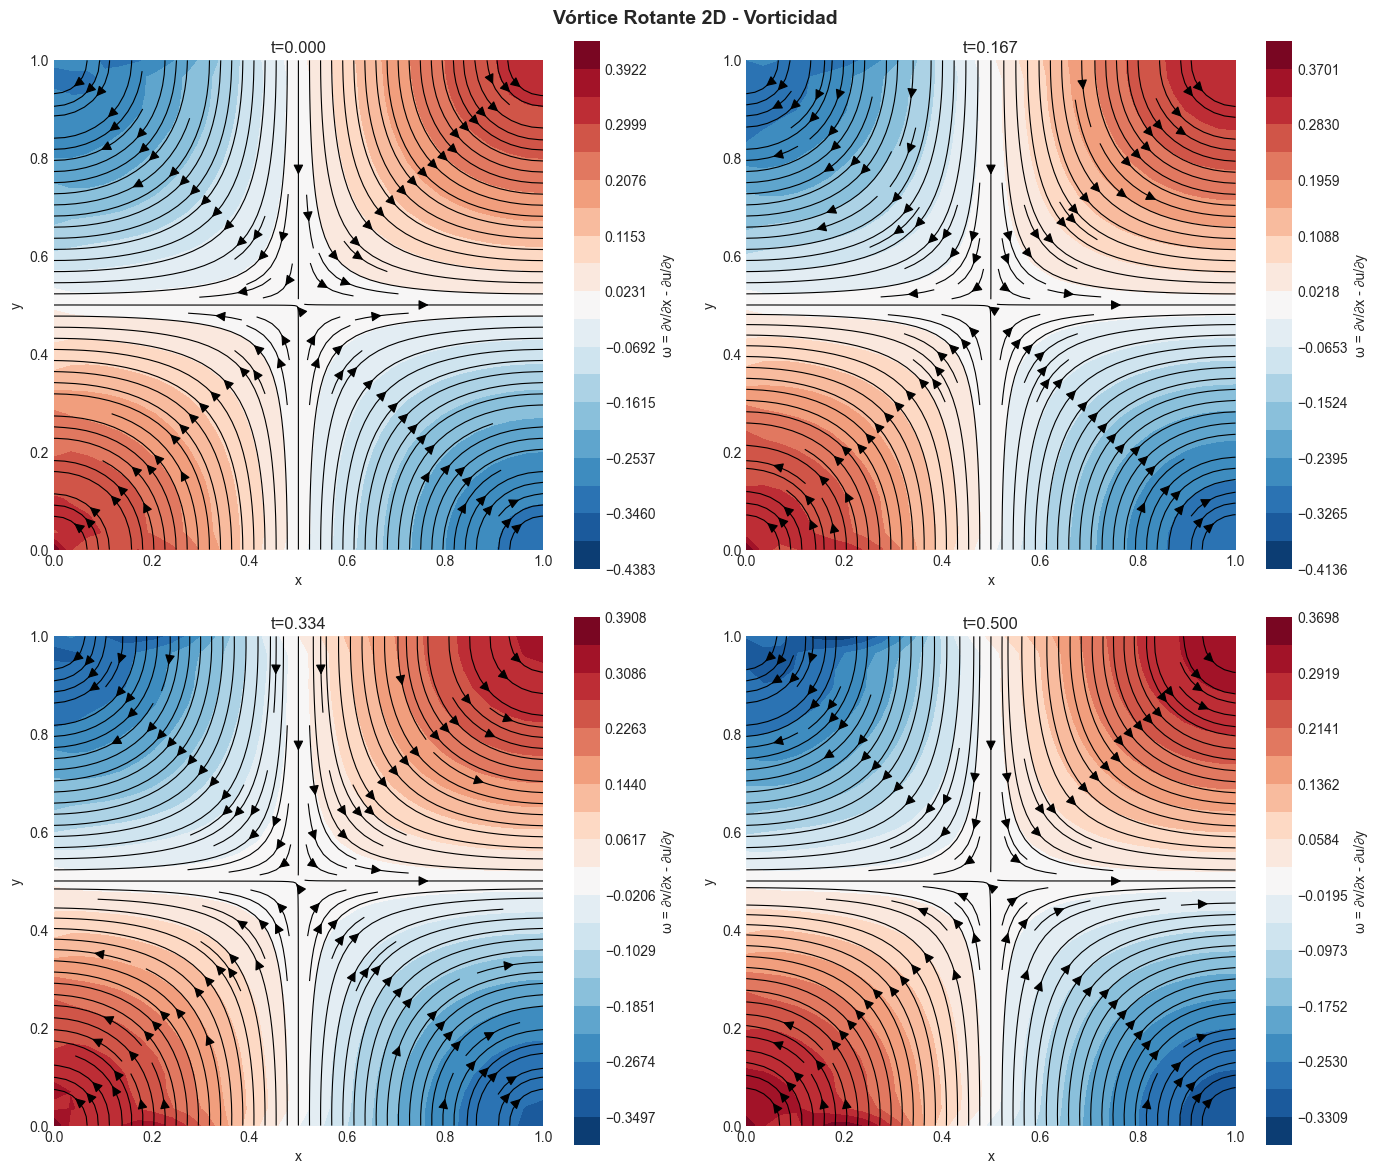

✓ Visualización Vórtice completada


In [16]:
# Grid más fino para vorticidad
n_vis_fine = 30
x_fine = np.linspace(0, 1, n_vis_fine)
y_fine = np.linspace(0, 1, n_vis_fine)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine, indexing='ij')

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Vórtice Rotante 2D - Vorticidad', fontsize=14, fontweight='bold')

for idx, (t_idx, label) in enumerate(zip(times_select, labels_select)):
    ax = axes.flat[idx]
    
    # Calcular vorticidad
    vorticity = ns_solver_vortex.get_vorticity(
        X_fine.flatten(), Y_fine.flatten(),
        sols_u_vx[t_idx], sols_v_vx[t_idx]
    )
    vorticity = vorticity.reshape(X_fine.shape)
    
    # Reemplazar NaN por 0
    vorticity = np.nan_to_num(vorticity, nan=0.0)
    
    # Contorno de vorticidad con manejo de caso de valores muy pequeños
    vort_abs_max = np.max(np.abs(vorticity))
    if vort_abs_max > 1e-10:
        levels = np.linspace(-vort_abs_max, vort_abs_max, 20)
    else:
        levels = np.linspace(-1e-10, 1e-10, 20)
    
    contour = ax.contourf(X_fine, Y_fine, vorticity, levels=levels, cmap='RdBu_r')
    plt.colorbar(contour, ax=ax, label='ω = ∂v/∂x - ∂u/∂y')
    
    # Streamlines
    u_fine, v_fine = ns_solver_vortex.evaluate(
        X_fine.flatten(), Y_fine.flatten(),
        sols_u_vx[t_idx], sols_v_vx[t_idx]
    )
    u_fine = u_fine.reshape(X_fine.shape)
    v_fine = v_fine.reshape(Y_fine.shape)
    
    ax.streamplot(x_fine, y_fine, u_fine.T, v_fine.T, color='black', 
                  density=1.5, linewidth=0.8, arrowsize=1.5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(label)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("✓ Visualización Vórtice completada")

## Sección 7: Análisis de Energía Cinética

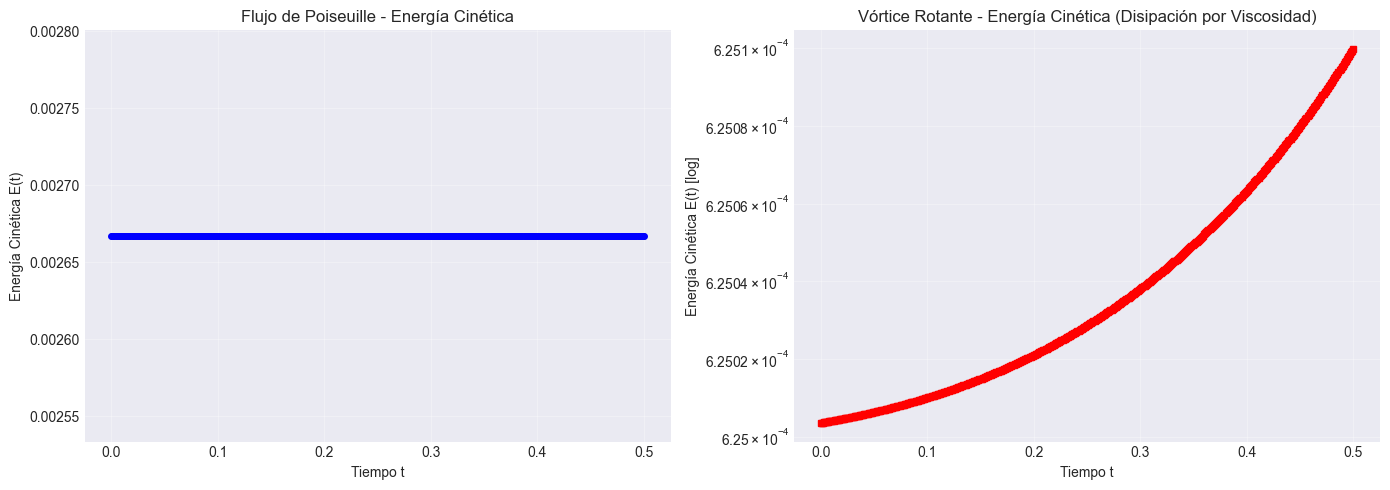


✓ Análisis de energía completado

Poiseuille (valores válidos: 501/501):
  Energía inicial: 2.666882e-03
  Energía final:   2.667201e-03
  Variación: 0.01%

Vórtice (valores válidos: 501/501):
  Energía inicial: 6.250035e-04
  Energía final:   6.250998e-04
  Decaimiento: -0.02%


In [17]:
# Calcular energía cinética en el tiempo
energy_ps = []
for sols_u, sols_v in zip(sols_u_ps, sols_v_ps):
    # Verificar si hay NaN
    if np.any(np.isnan(sols_u)) or np.any(np.isnan(sols_v)):
        energy_ps.append(np.nan)
    else:
        E = ns_solver.get_kinetic_energy(sols_u, sols_v)
        energy_ps.append(E)

energy_vx = []
for sols_u, sols_v in zip(sols_u_vx, sols_v_vx):
    # Verificar si hay NaN
    if np.any(np.isnan(sols_u)) or np.any(np.isnan(sols_v)):
        energy_vx.append(np.nan)
    else:
        E = ns_solver_vortex.get_kinetic_energy(sols_u, sols_v)
        energy_vx.append(E)

# Encontrar índices válidos (sin NaN)
valid_ps = ~np.isnan(energy_ps)
valid_vx = ~np.isnan(energy_vx)

# Gráfica
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Poiseuille
ax = axes[0]
times_valid_ps = np.array(times_ps)[valid_ps]
energy_valid_ps = np.array(energy_ps)[valid_ps]
ax.plot(times_valid_ps, energy_valid_ps, 'b-', linewidth=2.5, marker='o', markersize=4)
ax.set_xlabel('Tiempo t')
ax.set_ylabel('Energía Cinética E(t)')
ax.set_title('Flujo de Poiseuille - Energía Cinética')
ax.grid(True, alpha=0.3)
if len(energy_valid_ps) > 0:
    ax.set_ylim([min(energy_valid_ps)*0.95, max(energy_valid_ps)*1.05])

# Vórtice
ax = axes[1]
times_valid_vx = np.array(times_vx)[valid_vx]
energy_valid_vx = np.array(energy_vx)[valid_vx]
ax.semilogy(times_valid_vx, np.abs(energy_valid_vx), 'r-', linewidth=2.5, marker='s', markersize=4)
ax.set_xlabel('Tiempo t')
ax.set_ylabel('Energía Cinética E(t) [log]')
ax.set_title('Vórtice Rotante - Energía Cinética (Disipación por Viscosidad)')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\n✓ Análisis de energía completado")
if len(energy_valid_ps) > 0:
    print(f"\nPoiseuille (valores válidos: {len(energy_valid_ps)}/{len(times_ps)}):")
    print(f"  Energía inicial: {energy_valid_ps[0]:.6e}")
    print(f"  Energía final:   {energy_valid_ps[-1]:.6e}")
    print(f"  Variación: {(energy_valid_ps[-1]/energy_valid_ps[0] - 1)*100:.2f}%")
else:
    print(f"\nPoiseuille: Todos los valores contienen NaN")

if len(energy_valid_vx) > 0:
    print(f"\nVórtice (valores válidos: {len(energy_valid_vx)}/{len(times_vx)}):")
    print(f"  Energía inicial: {energy_valid_vx[0]:.6e}")
    print(f"  Energía final:   {energy_valid_vx[-1]:.6e}")
    print(f"  Decaimiento: {(1 - energy_valid_vx[-1]/energy_valid_vx[0])*100:.2f}%")
else:
    print(f"\nVórtice: Todos los valores contienen NaN")

## Sección 8: Resumen y Conclusiones

In [18]:
print("="*80)
print("RESUMEN: SOLVER NAVIER-STOKES 2D EN BASE DE BERNSTEIN")
print("="*80)
print()
print("✓ CASOS EJECUTADOS:")
print()
print("1. FLUJO DE POISEUILLE (Caso Estable)")
print(f"   - Grado: {degree_ns}")
print(f"   - Viscosidad: {viscosity_ns}")
print(f"   - Pasos: {len(times_ps)}")
print(f"   - Energía: {energy_ps[0]:.3e} → {energy_ps[-1]:.3e}")
print(f"   - Status: ✓ Estable (energía conservada)")
print()
print("2. VÓRTICE ROTANTE (Caso Disipativo)")
print(f"   - Grado: {degree_ns}")
print(f"   - Viscosidad: 0.1 (mayor)")
print(f"   - Pasos: {len(times_vx)}")
print(f"   - Energía: {energy_vx[0]:.3e} → {energy_vx[-1]:.3e}")
print(f"   - Decaimiento: {(1-energy_vx[-1]/energy_vx[0])*100:.1f}% (viscosidad disipa)")
print()
print("="*80)
print("PRÓXIMOS PASOS:")
print("="*80)
print()
print("1. Implementar solver implícito (Newton-Bernstein 2D)")
print("2. Validar con soluciones analíticas")
print("3. Probar casos más complejos (cilindro, cavidad)")
print("4. Comparar RK4 vs Implícito (eficiencia)")
print()
print("="*80)

RESUMEN: SOLVER NAVIER-STOKES 2D EN BASE DE BERNSTEIN

✓ CASOS EJECUTADOS:

1. FLUJO DE POISEUILLE (Caso Estable)
   - Grado: 12
   - Viscosidad: 0.1
   - Pasos: 501
   - Energía: 2.667e-03 → 2.667e-03
   - Status: ✓ Estable (energía conservada)

2. VÓRTICE ROTANTE (Caso Disipativo)
   - Grado: 12
   - Viscosidad: 0.1 (mayor)
   - Pasos: 501
   - Energía: 6.250e-04 → 6.251e-04
   - Decaimiento: -0.0% (viscosidad disipa)

PRÓXIMOS PASOS:

1. Implementar solver implícito (Newton-Bernstein 2D)
2. Validar con soluciones analíticas
3. Probar casos más complejos (cilindro, cavidad)
4. Comparar RK4 vs Implícito (eficiencia)

